In [5]:
"""
created on March 8th 2019

@author: Huan Zheng
"""
# RNN高级用法

'\ncreated on March 8th 2019\n\n@author: Huan Zheng\n'

# 温度预测问题
## 耶拿天气数据

In [8]:
import pandas as pd
data = pd.read_csv('jena_climate_2009_2016.csv')

In [10]:
import os

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [11]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

## 绘制温度时间序列

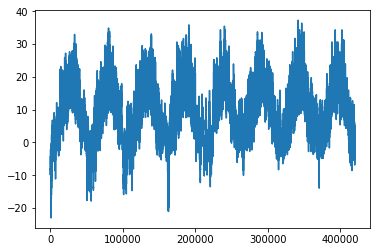

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

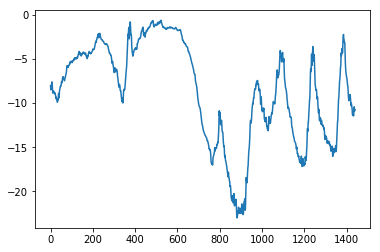

In [4]:
plt.plot(range(1440), temp[:1440])

# 准备数据

## 数据标准化

In [14]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## 生成时间序列样本及其目标的生成器

In [15]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

## 准备训练生成器、验证生成器和测试生成器

In [16]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 一种基于常识的、非机器学习的基准方法

## 计算符合常识的基准方法的MAE

In [34]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## 将MAE转化为摄氏度误差

In [35]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

# 一种基本的机器学习方法

## 训练并评估一个密集连接模型

In [38]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 23s 46ms/step - loss: 1.0878 - val_loss: 0.4512
Epoch 2/20
500/500 [==============================] - 23s 47ms/step - loss: 0.4255 - val_loss: 0.3255
Epoch 3/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2967 - val_loss: 0.3135
Epoch 4/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2688 - val_loss: 0.3144
Epoch 5/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2542 - val_loss: 0.3101
Epoch 6/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2459 - val_loss: 0.3086
Epoch 7/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2404 - val_loss: 0.3159
Epoch 8/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2329 - val_loss: 0.3134
Epoch 9/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2304 - val_loss: 0.3364
Epoch 10/20
500/500 [==============================] - 24s 47ms/step - loss: 0.226

## 结果可视化

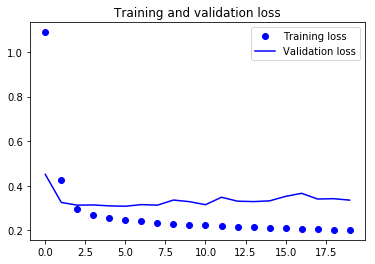

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 第一个循环神经网络基准
## 训练并评估一个基于GRU的模型

In [45]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 272s 3s/step - loss: 0.3555 - val_loss: 0.2910
Epoch 2/20
100/100 [==============================] - 264s 3s/step - loss: 0.3015 - val_loss: 0.2811
Epoch 3/20
100/100 [==============================] - 287s 3s/step - loss: 0.2969 - val_loss: 0.2755
Epoch 4/20
100/100 [==============================] - 290s 3s/step - loss: 0.2930 - val_loss: 0.2771
Epoch 5/20
100/100 [==============================] - 288s 3s/step - loss: 0.2894 - val_loss: 0.2734
Epoch 6/20
100/100 [==============================] - 278s 3s/step - loss: 0.2895 - val_loss: 0.2693
Epoch 7/20
100/100 [==============================] - 277s 3s/step - loss: 0.2881 - val_loss: 0.2682
Epoch 8/20
100/100 [==============================] - 281s 3s/step - loss: 0.2832 - val_loss: 0.2722
Epoch 9/20
100/100 [==============================] - 273s 3s/step - loss: 0.2860 - val_loss: 0.2673
Epoch 10/20
100/100 [==============================] - 264s 3s/step - loss: 0.2807 - val_lo

## 结果可视化

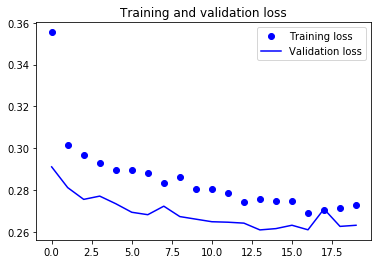

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 使用循环dropout来降低过拟合
## 训练并评估一个使用dropout正则化的基于GRU的模型

In [51]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=25, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
25/25 [==============================] - 226s 9s/step - loss: 0.4364 - val_loss: 0.3071
Epoch 2/20
25/25 [==============================] - 223s 9s/step - loss: 0.3726 - val_loss: 0.2964
Epoch 3/20
25/25 [==============================] - 224s 9s/step - loss: 0.3469 - val_loss: 0.2889
Epoch 4/20
25/25 [==============================] - 246s 10s/step - loss: 0.3393 - val_loss: 0.2850
Epoch 5/20
25/25 [==============================] - 237s 9s/step - loss: 0.3347 - val_loss: 0.2880
Epoch 6/20
25/25 [==============================] - 225s 9s/step - loss: 0.3413 - val_loss: 0.2841
Epoch 7/20
25/25 [==============================] - 222s 9s/step - loss: 0.3332 - val_loss: 0.2869
Epoch 8/20
25/25 [==============================] - 221s 9s/step - loss: 0.3222 - val_loss: 0.2815
Epoch 9/20
25/25 [==============================] - 222s 9s/step - loss: 0.3286 - val_loss: 0.2818
Epoch 10/20
25/25 [==============================] - 222s 9s/step - loss: 0.3261 - val_loss: 0.2807
Epoch 11

## 结果可视化

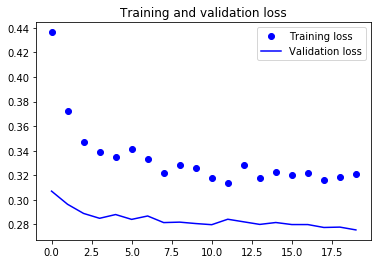

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 循环堆叠层
## 训练并评估一个使用dropout正则化的堆叠GRU模型

In [54]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=25, epochs=10, validation_data=val_gen, validation_steps=25)

Epoch 1/10
25/25 [==============================] - 76s 3s/step - loss: 0.4417 - val_loss: 0.2801
Epoch 2/10
25/25 [==============================] - 73s 3s/step - loss: 0.3640 - val_loss: 0.3246
Epoch 3/10
25/25 [==============================] - 75s 3s/step - loss: 0.3500 - val_loss: 0.2878
Epoch 4/10
25/25 [==============================] - 76s 3s/step - loss: 0.3464 - val_loss: 0.2197
Epoch 5/10
25/25 [==============================] - 82s 3s/step - loss: 0.3390 - val_loss: 0.2671
Epoch 6/10
25/25 [==============================] - 82s 3s/step - loss: 0.3372 - val_loss: 0.2736
Epoch 7/10
25/25 [==============================] - 98s 4s/step - loss: 0.3303 - val_loss: 0.2226
Epoch 8/10
25/25 [==============================] - 85s 3s/step - loss: 0.3332 - val_loss: 0.3684
Epoch 9/10
25/25 [==============================] - 81s 3s/step - loss: 0.3386 - val_loss: 0.3273
Epoch 10/10
25/25 [==============================] - 85s 3s/step - loss: 0.3289 - val_loss: 0.2533


## 结果可视化

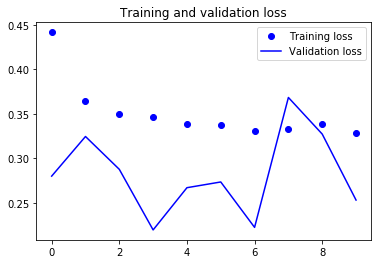

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 使用双向RNN
## 使用逆序序列训练并评估一个LSTM

In [4]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 将序列反转
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 填充序列
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=1, batch_size=512, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 120s 6ms/step - loss: 0.6383 - acc: 0.6625 - val_loss: 0.5242 - val_acc: 0.7746


## 训练并评估一个双向LSTM

In [7]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=1, batch_size=512, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 267s 13ms/step - loss: 0.6224 - acc: 0.6630 - val_loss: 0.4833 - val_acc: 0.8044


## 训练一个双向GRU

In [19]:
from keras.optimizers import RMSprop
from keras import layers
from keras.models import Sequential

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=25, epochs=4, validation_data=val_gen, validation_steps=25)

Epoch 1/4
25/25 [==============================] - 62s 2s/step - loss: 0.3753 - val_loss: 0.3138
Epoch 2/4
25/25 [==============================] - 59s 2s/step - loss: 0.3200 - val_loss: 0.3144
Epoch 3/4
25/25 [==============================] - 59s 2s/step - loss: 0.3028 - val_loss: 0.1951
Epoch 4/4
25/25 [==============================] - 59s 2s/step - loss: 0.2965 - val_loss: 0.3473


## 结果可视化

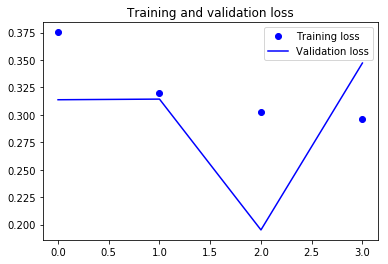

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()